In [1]:
import sys
import os
import json
import numpy as np
from collections import defaultdict, Counter
import utils

In [2]:
os.environ['PT_DATA_DIR'] = '/home/hoyeung/blob_matterport3d/'
PT_DATA_DIR = '/home/hoyeung/blob_matterport3d/'
PT_OUTPUT_DIR = '/home/hoyeung/blob_experiments/output_philly/'

In [3]:
PT_EXP_NAME = '20200221_philly_aggrevate_costtogo_logging/'
JOB_NAME = "eval_best_250_512_model/"

### Load Data

In [4]:
# Val seen data
with open(PT_DATA_DIR + 'asknav/asknav_val_seen.json', "r") as f:
    val_seen_data = json.load(f)
    
# Val unseen data
with open(PT_DATA_DIR + 'asknav/asknav_val_unseen.json', "r") as f:
    val_unseen_data = json.load(f)

In [5]:
# l1 results
with open(PT_OUTPUT_DIR + PT_EXP_NAME + JOB_NAME + "value_estimation_no_ask_no_recovery_val_seen_for_eval.json", "r") as f:
    val_seen_l1_results = json.load(f)
    
with open(PT_OUTPUT_DIR + PT_EXP_NAME + JOB_NAME + "value_estimation_no_ask_no_recovery_val_unseen_for_eval.json", "r") as f:
    val_unseen_l1_results = json.load(f)

In [6]:
# l2 results
with open(PT_OUTPUT_DIR + PT_EXP_NAME + JOB_NAME + "value_estimation_no_ask_no_recovery_val_seen_for_eval.json", "r") as f:
    val_seen_l2_results = json.load(f)
    
with open(PT_OUTPUT_DIR + PT_EXP_NAME + JOB_NAME + "value_estimation_no_ask_no_recovery_val_unseen_for_eval.json", "r") as f:
    val_unseen_l2_results = json.load(f)

### Examine

In [17]:
val_seen_l1_results[0].keys()

dict_keys(['agent_q_values', 'expert_rollin_bool', 'instr_id', 'teacher_q_values', 'trajectory', 'teacher_cost_stepping', 'teacher_cost_togo', 'agent_nav', 'beta', 'scan'])

In [18]:
val_seen_data[0].keys()

dict_keys(['end_regions', 'instructions', 'object_name', 'paths', 'end_region_name', 'trajectories', 'object_indices', 'scan', 'path_id', 'heading', 'start_region', 'distances', 'start_region_name'])

In [19]:
val_seen_data[0]['paths']

[['6cba04f9e76f463094dd2a6ff64d1e9f',
  '9e3bb94fbf7f4dc0a74911414ca95753',
  '7980b9f903164d48aaee2dbeb5615796',
  'c9ac0c98d16a4105a3214989cac149c0',
  '48a2541fc50b4a57a609698e2375e9b1',
  '4547d37b305e41bdad0de45ade6971ca',
  '6ab11272308c46068c9ae583da8ff311',
  'd2600c4cac6445a7b7f0eef51a074043'],
 ['6cba04f9e76f463094dd2a6ff64d1e9f',
  '9096013c3596463b9c0500520d12fef1',
  '39791f422b0244aa84b3d41d9b218f7e',
  '3182b6eba9ce405f9e1c0af86cc6b862',
  '97739a403b984dcd8253741a073b18dd']]

In [20]:
val_seen_l1_results[0]['instr_id']

'72022_0'

In [21]:
len(val_seen_l1_results[0]['agent_q_values'])

10

In [22]:
len(val_seen_l1_results[0]['agent_q_values'][0])

36

In [23]:
len(val_seen_l1_results[0]['teacher_q_values'])

10

In [24]:
len(val_seen_l1_results[0]['teacher_q_values'][0])

36

In [25]:
val_seen_l1_results[0]['trajectory']

[['949a6c58781d4e80bff19ca32493efcd', 2.617993877991494, 0.0],
 ['949a6c58781d4e80bff19ca32493efcd', 1.5707963267948966, 0.0],
 ['f5cf1375de4d46b38328dda8ebcd6ce0', 1.5707963267948966, 0.0],
 ['f5cf1375de4d46b38328dda8ebcd6ce0', 4.71238898038469, 0.0],
 ['949a6c58781d4e80bff19ca32493efcd', 4.71238898038469, 0.0],
 ['949a6c58781d4e80bff19ca32493efcd', 1.5707963267948966, 0.0],
 ['f5cf1375de4d46b38328dda8ebcd6ce0', 1.5707963267948966, 0.0],
 ['f5cf1375de4d46b38328dda8ebcd6ce0', 5.759586531581287, 0.0],
 ['32c98b5cfe804dd185a8cb6ecb91a63f', 5.759586531581287, 0.0],
 ['32c98b5cfe804dd185a8cb6ecb91a63f', 2.617993877991494, 0.0],
 ['f5cf1375de4d46b38328dda8ebcd6ce0', 2.617993877991494, 0.0],
 ['f5cf1375de4d46b38328dda8ebcd6ce0', 4.71238898038469, 0.0],
 ['949a6c58781d4e80bff19ca32493efcd', 4.71238898038469, 0.0],
 ['949a6c58781d4e80bff19ca32493efcd', 2.0943951023931953, 0.0],
 ['860f7e4e9a944bbd856dfcc5f2d1ad2b', 2.0943951023931953, 0.0],
 ['860f7e4e9a944bbd856dfcc5f2d1ad2b', 0.5235987755982

In [26]:
val_seen_data[0]['path_id']

193069

### Partition by gold trajectory length

In [27]:
len([res for res in val_seen_l1_results if '_0' in res['instr_id']])

4874

In [28]:
val_seen_gold_traj_lengths = {dat['path_id']: min([len(p) for p in dat['paths']]) for dat in val_seen_data}
val_unseen_gold_traj_lengths = {dat['path_id']: min([len(p) for p in dat['paths']]) for dat in val_unseen_data}

### Compute loss per task

In [29]:
def l1_loss_func_per_sphere(pred, tar):
    assert np.sum(pred == 1e9) == np.sum(tar == 1e9)
    
    pred = np.array(pred)
    tar  = np.array(tar)
    tot  = 36 - np.sum(pred == 1e9)
    assert tot > 0
    
    return np.sum(np.abs(np.array(pred) - np.array(tar))) / tot

In [30]:
def l2_loss_func_per_sphere(pred, tar):
    assert np.sum(pred == 1e9) == np.sum(tar == 1e9)
    
    pred = np.array(pred)
    tar  = np.array(tar)
    tot  = 36 - np.sum(pred == 1e9)
    assert tot > 0
    
    return np.sum((np.array(pred) - np.array(tar))**2) / tot

In [31]:
def loss_per_task(loss_func, task):
    time_steps = len(task['agent_q_values'])
    task_loss = np.mean([loss_func(task['agent_q_values'][t], task['teacher_q_values'][t]) for t in range(time_steps)])
    return task_loss, time_steps

In [11]:
loss, steps = loss_per_task(l1_loss_func_per_sphere, val_seen_l1_results[70])
loss

3.1724950412149107

In [32]:
loss, steps = loss_per_task(l1_loss_func_per_sphere, val_seen_l1_results[70])
loss

2.2591421717479174

In [33]:
loss, steps = loss_per_task(l2_loss_func_per_sphere, val_seen_l1_results[70])
loss

9.054625386368778

In [35]:
def loss_per_task_by_time_steps(loss_func, task):
    time_steps = len(task['agent_q_values'])
    task_losses = {t: loss_func(task['agent_q_values'][t], task['teacher_q_values'][t]) for t in range(time_steps)}
    return task_losses, time_steps

In [38]:
losses, steps = loss_per_task_by_time_steps(l1_loss_func_per_sphere, val_seen_l1_results[70])
losses

{0: 0.6663593237764076,
 1: 0.5744290152669072,
 2: 0.8699452239431661,
 3: 2.1231598964308636,
 4: 2.959133963839193,
 5: 4.037565847123462,
 6: 3.302488570467611,
 7: 3.54005553313573}

In [39]:
losses, steps = loss_per_task_by_time_steps(l2_loss_func_per_sphere, val_seen_l1_results[70])
losses

{0: 0.5018353238162249,
 1: 0.6496562166545202,
 2: 0.9475862773686442,
 3: 6.3938864204705865,
 4: 12.916936564787779,
 5: 21.23246938279027,
 6: 13.85521546912272,
 7: 15.939417435939486}

### Loop through results

In [40]:
def make_idx_loss_map(results, gold_lengths):
    idx_loss_map = {}

    for task in results:
        l1_loss, timesteps = loss_per_task(l1_loss_func_per_sphere, task)
        l2_loss, _ = loss_per_task(l2_loss_func_per_sphere, task)
        path_id = int(task['instr_id'].split("_")[0])
        
        gold_traj_len = gold_lengths[path_id]

        idx_loss_map[path_id] = {'gold_len':gold_traj_len, 'l1_loss':l1_loss, 'l2_loss':l2_loss, 'rollout_len':timesteps}
    
    return idx_loss_map

In [41]:
idx_loss_map_val_seen_l1 = make_idx_loss_map(val_seen_l1_results, val_seen_gold_traj_lengths)
idx_loss_map_val_unseen_l1 = make_idx_loss_map(val_unseen_l1_results, val_unseen_gold_traj_lengths)

idx_loss_map_val_seen_l2 = make_idx_loss_map(val_seen_l2_results, val_seen_gold_traj_lengths)
idx_loss_map_val_unseen_l2 = make_idx_loss_map(val_unseen_l2_results, val_unseen_gold_traj_lengths)

In [42]:
def make_idx_loss_by_time_step_map(results, gold_lengths):
    idx_losses_map = {}

    for task in results:
        l1_losses, timesteps = loss_per_task_by_time_steps(l1_loss_func_per_sphere, task)
        l2_losses, _ = loss_per_task_by_time_steps(l2_loss_func_per_sphere, task)
        path_id = int(task['instr_id'].split("_")[0])
        
        gold_traj_len = gold_lengths[path_id]

        idx_losses_map[path_id] = {'gold_len':gold_traj_len, 'l1_loss':l1_losses, 'l2_loss':l2_losses, 'rollout_len':timesteps}
    
    return idx_losses_map

In [43]:
idx_loss_by_time_map_val_seen_l1 = make_idx_loss_by_time_step_map(val_seen_l1_results, val_seen_gold_traj_lengths)
idx_loss_by_time_map_val_unseen_l1 = make_idx_loss_by_time_step_map(val_unseen_l1_results, val_unseen_gold_traj_lengths)

idx_loss_by_time_map_val_seen_l2 = make_idx_loss_by_time_step_map(val_seen_l2_results, val_seen_gold_traj_lengths)
idx_loss_by_time_map_val_unseen_l2 = make_idx_loss_by_time_step_map(val_unseen_l2_results, val_unseen_gold_traj_lengths)

### Group by gold traj lengths

In [44]:
def compute_len_group_avg(idx_loss_map, loss_str):

    gold_length_to_loss = {i:[] for i in range(30)}

    for idx in idx_loss_map:
        task = idx_loss_map[idx]
        gold_length_to_loss[task['gold_len']].append(task[loss_str])

    gold_length_to_loss_avg = {i: np.mean(gold_length_to_loss[i]) for i in range(30)}
    
    return gold_length_to_loss_avg

In [45]:
len_group_avg_val_seen_l1 = compute_len_group_avg(idx_loss_map_val_seen_l1, 'l1_loss')
len_group_avg_val_seen_l2 = compute_len_group_avg(idx_loss_map_val_seen_l2, 'l2_loss')

/data/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [46]:
len_group_avg_val_unseen_l1 = compute_len_group_avg(idx_loss_map_val_unseen_l1, 'l1_loss')
len_group_avg_val_unseen_l2 = compute_len_group_avg(idx_loss_map_val_unseen_l2, 'l2_loss')

/data/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Set 1: Plot loss by gold trajectory lengths of task

In [47]:
import matplotlib.pyplot as plt

In [111]:
def plot(len_group_avg, x_label, loss_str):
    x = np.array([gold_len for gold_len, loss_avg in len_group_avg.items()])
    height = np.array([loss_avg for gold_len, loss_avg in len_group_avg.items()])
    plt.figure(figsize=(20,10))
    plt.bar(x, height, width=0.8)
    plt.ylabel("Loss {}".format(loss_str))
    plt.xlabel(x_label)

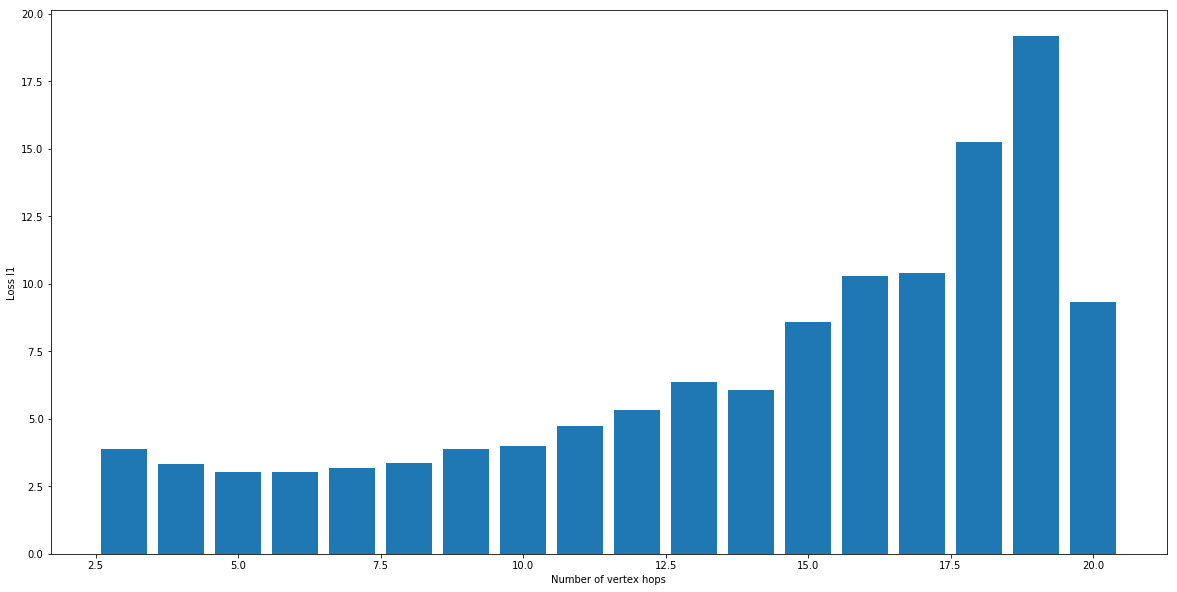

In [112]:
plot(len_group_avg_val_seen_l1, "Number of vertex hops", "l1")

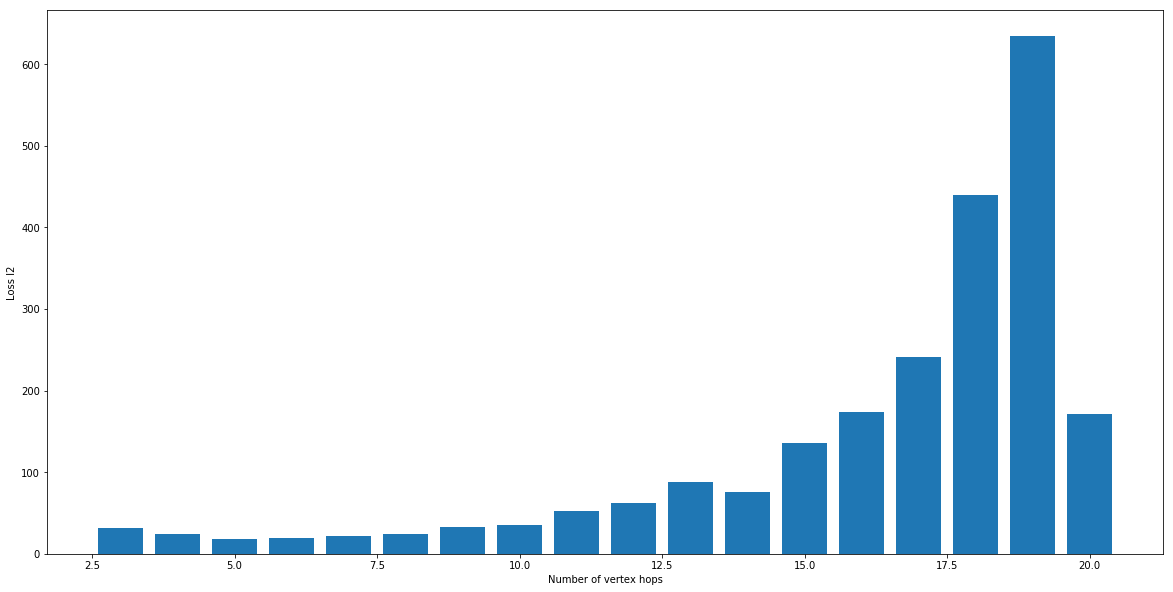

In [113]:
plot(len_group_avg_val_seen_l2, "Number of vertex hops", 'l2')

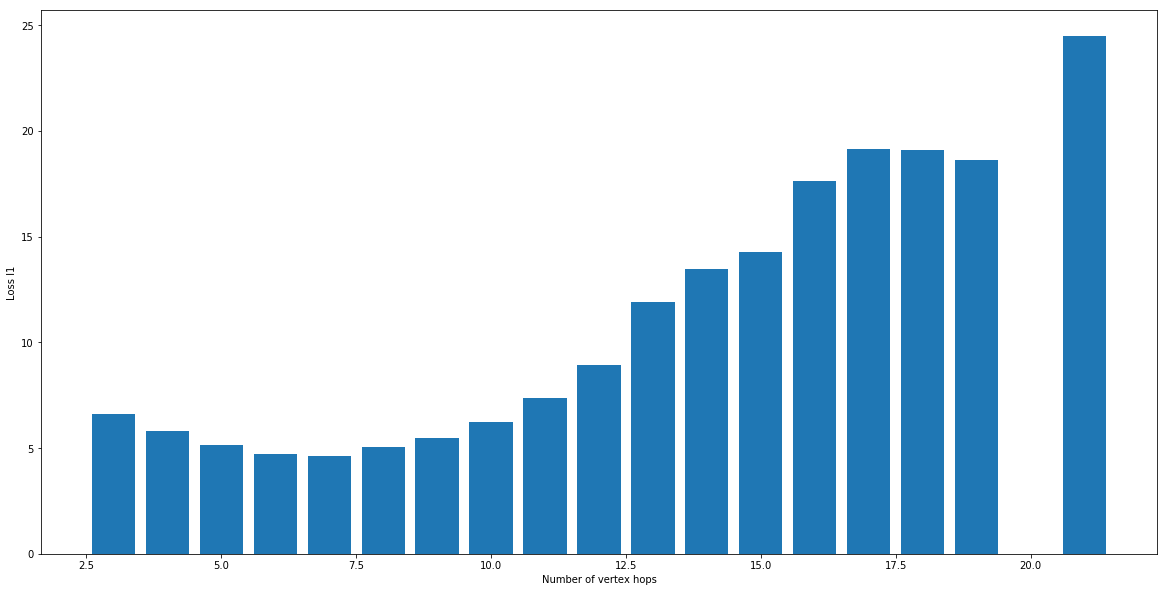

In [114]:
plot(len_group_avg_val_unseen_l1, "Number of vertex hops", 'l1')

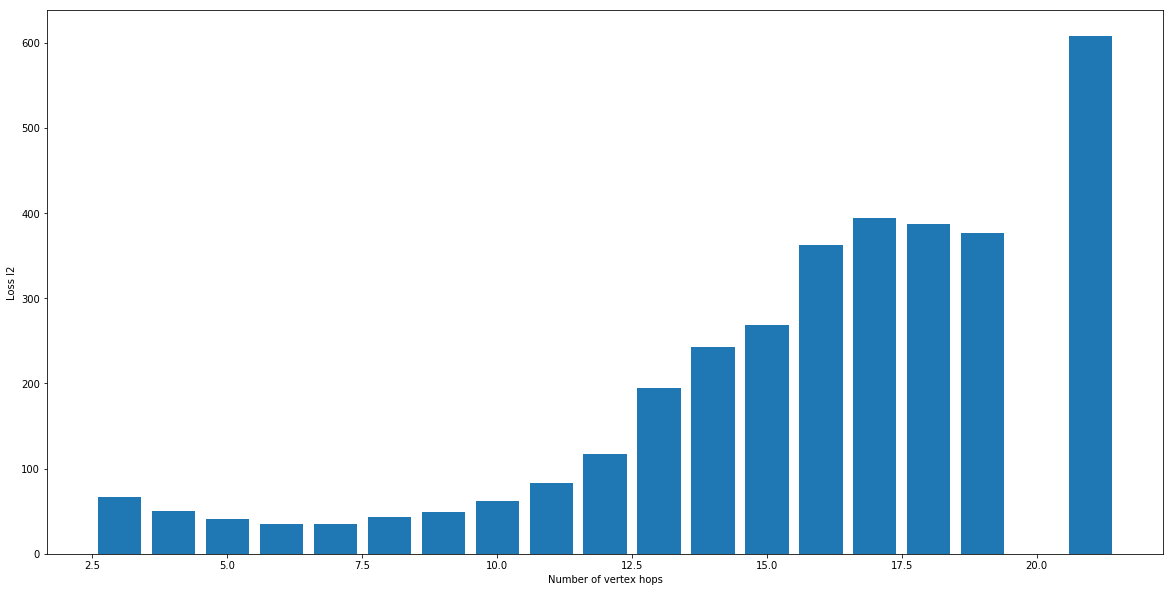

In [115]:
plot(len_group_avg_val_unseen_l2, "Number of vertex hops", 'l2')

### Group by timesteps

In [116]:
def comput_timestep_group_avg(idx_loss_by_time_map, loss_str):
    
    timestep_to_loss = {t:[] for t in range(30)}
    
    for idx in idx_loss_by_time_map:
        task = idx_loss_by_time_map[idx]
        for t in task[loss_str]:
            timestep_to_loss[t].append(task[loss_str][t])
    
#     import pdb; pdb.set_trace()
    timestep_to_loss_avg = {i: np.mean(timestep_to_loss[i]) for i in range(30)}
    
    return timestep_to_loss_avg

In [117]:
timestep_group_avg_val_seen_l1 = comput_timestep_group_avg(idx_loss_by_time_map_val_seen_l1, 'l1_loss')
timestep_group_avg_val_seen_l2 = comput_timestep_group_avg(idx_loss_by_time_map_val_seen_l2, 'l2_loss')

timestep_group_avg_val_unseen_l1 = comput_timestep_group_avg(idx_loss_by_time_map_val_unseen_l1, 'l1_loss')
timestep_group_avg_val_unseen_l2 = comput_timestep_group_avg(idx_loss_by_time_map_val_unseen_l2, 'l2_loss')

/data/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


## Set 2: Plot loss by Number of timesteps into episode

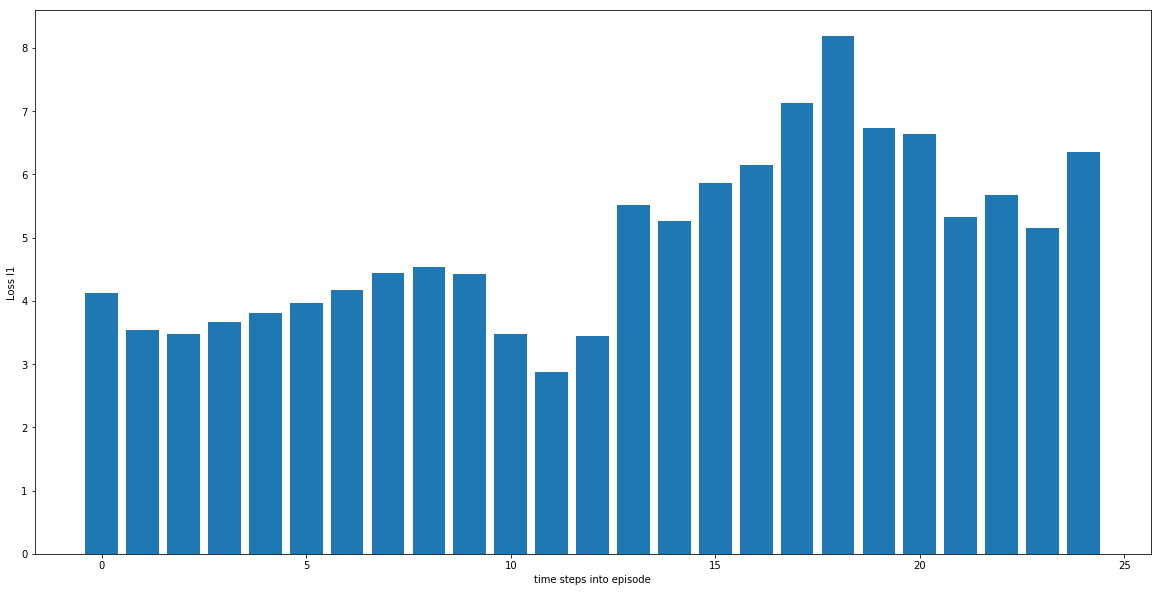

In [118]:
plot(timestep_group_avg_val_seen_l1, "time steps into episode", "l1")

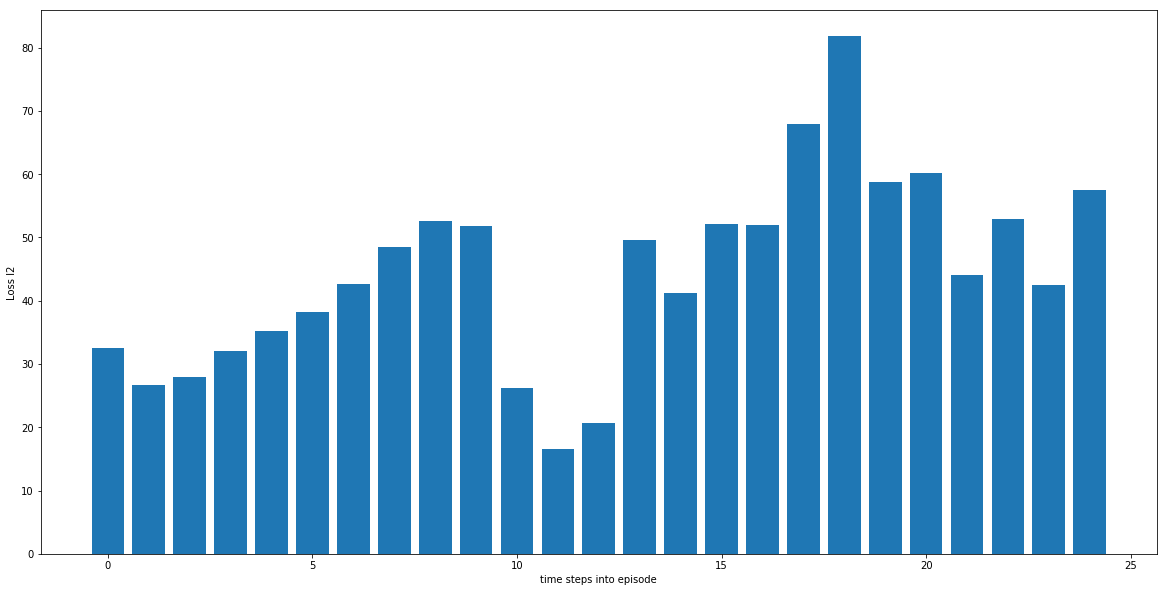

In [119]:
plot(timestep_group_avg_val_seen_l2, "time steps into episode", "l2")

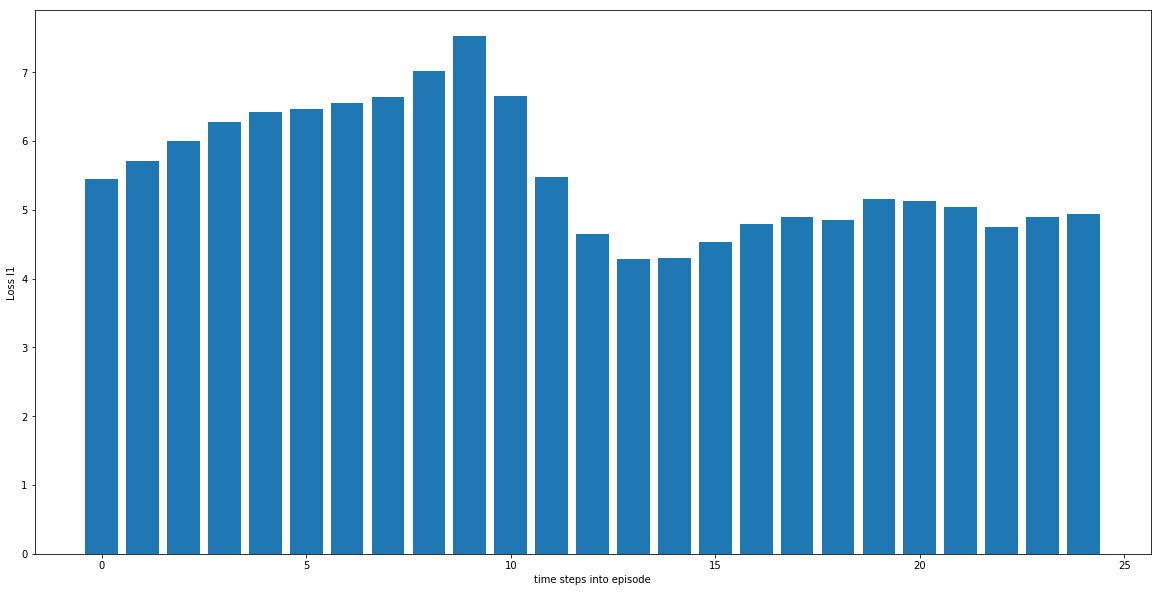

In [120]:
plot(timestep_group_avg_val_unseen_l1, "time steps into episode", "l1")

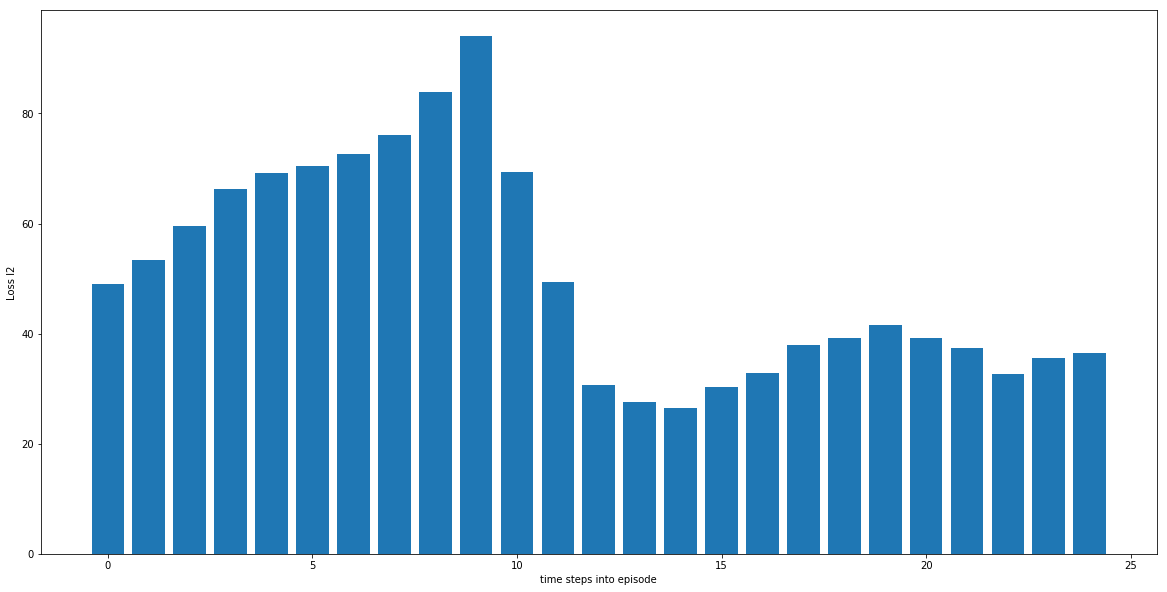

In [121]:
plot(timestep_group_avg_val_unseen_l2, "time steps into episode", "l2")

### What are the q-value sizes?

In [62]:
tar = []
pred = []

for res in val_seen_l1_results:
    timesteps = len(res['agent_q_values'])
    for t in range(timesteps):
        tar += [val for val in res['teacher_q_values'][t] if val != 1e9]
        pred += [val for val in res['agent_q_values'][t] if val != 1e9]

In [63]:
max(tar), min(tar)

(56.509506174029944, 0.3287194101357572)

In [64]:
max(pred), min(pred)

(51.936134338378906, 0.6108593940734863)

In [65]:
tar = []
pred = []

for res in val_seen_l2_results:
    timesteps = len(res['agent_q_values'])
    for t in range(timesteps):
        tar += [val for val in res['teacher_q_values'][t] if val != 1e9]
        pred += [val for val in res['agent_q_values'][t] if val != 1e9]

In [66]:
max(tar), min(tar)

(56.509506174029944, 0.3287194101357572)

In [67]:
max(pred), min(pred)

(51.936134338378906, 0.6108593940734863)

## Set 3: Plot loss by expert (cost-to-go + cost-stepping)

In [68]:
def compute_loss_by_q_targets(results):

    tars = []
    preds = []

    for task in results:

        timesteps = len(task['agent_q_values'])

        for t in range(timesteps):
            tars += [val for val in task['teacher_q_values'][t] if val != 1e9]
            preds += [val for val in task['agent_q_values'][t] if val != 1e9]

    l1_losses = np.abs(np.array(tars) - np.array(preds))
    l2_losses = (np.array(tars) - np.array(preds))**2

    return np.array(tars), np.array(preds), l1_losses, l2_losses

In [69]:
val_seen_l1_tars, val_seen_l1_preds, val_seen_l1_losses, _ = compute_loss_by_q_targets(val_seen_l1_results)
val_seen_l2_tars, val_seen_l2_preds, _, val_seen_l2_losses = compute_loss_by_q_targets(val_seen_l2_results)

val_unseen_l1_tars, val_unseen_l1_preds, val_unseen_l1_losses, _ = compute_loss_by_q_targets(val_unseen_l1_results)
val_unseen_l2_tars, val_unseen_l2_preds, _, val_unseen_l2_losses = compute_loss_by_q_targets(val_unseen_l2_results)

In [130]:
def plot_loss_grouped_by_q_target_size(results, loss_str, sample_size=5000):
    tars, preds, l1_losses, l2_losses = compute_loss_by_q_targets(results)
    indices = np.random.choice(len(tars), size=sample_size)
  
    plt.figure(figsize=(20,10))
    if loss_str == 'l1':
        plt.bar(tars[indices], l1_losses[indices])
    else:
        plt.bar(tars[indices], l2_losses[indices])
    plt.xlabel('Expert Cost-to-go + Cost-stepping in meters')
    plt.ylabel(loss_str)

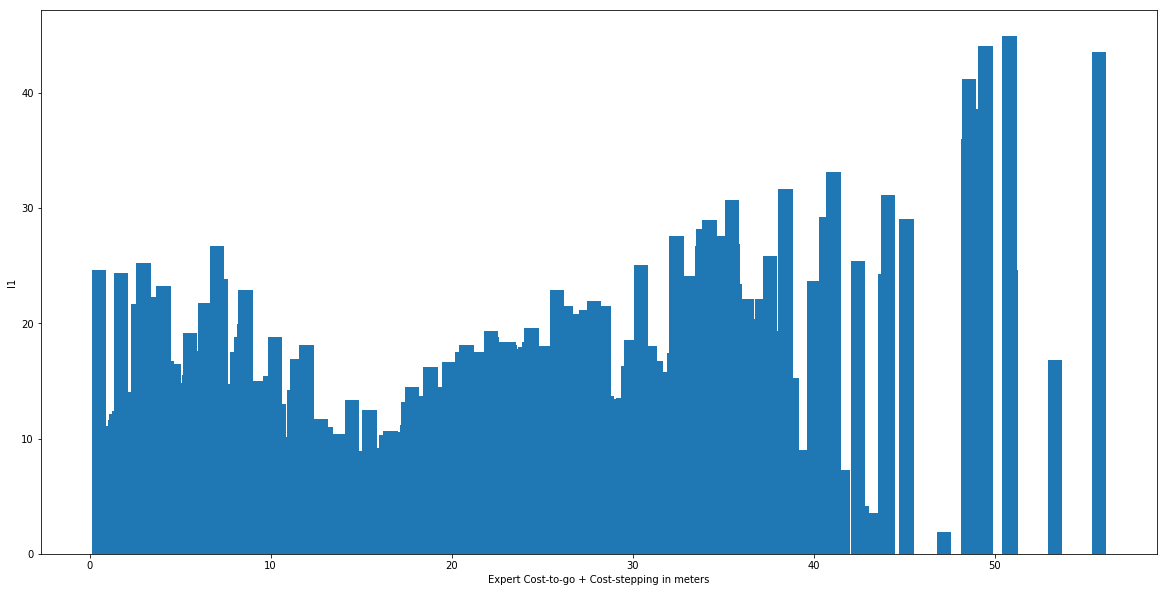

In [131]:
plot_loss_grouped_by_q_target_size(val_seen_l1_results, 'l1')

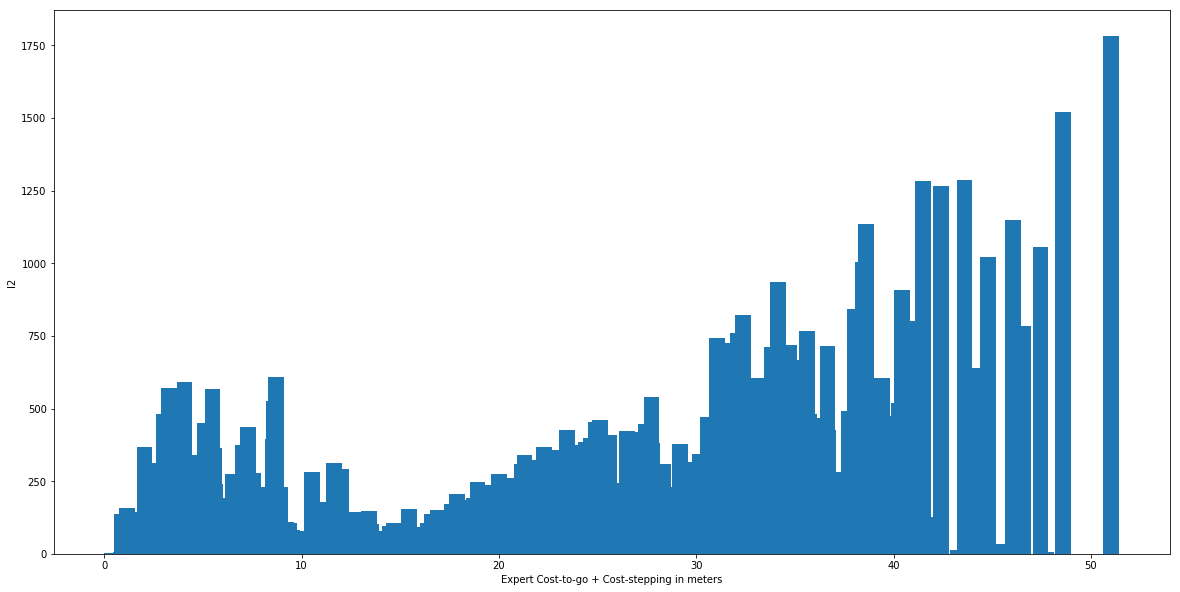

In [132]:
plot_loss_grouped_by_q_target_size(val_seen_l2_results, 'l2')

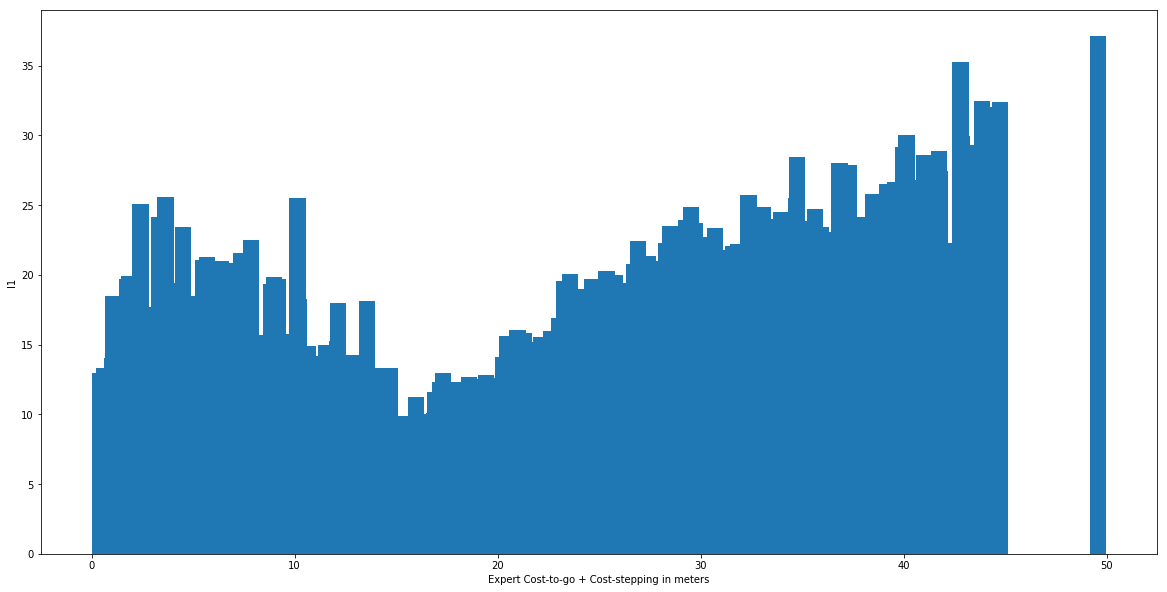

In [133]:
plot_loss_grouped_by_q_target_size(val_unseen_l1_results, 'l1')

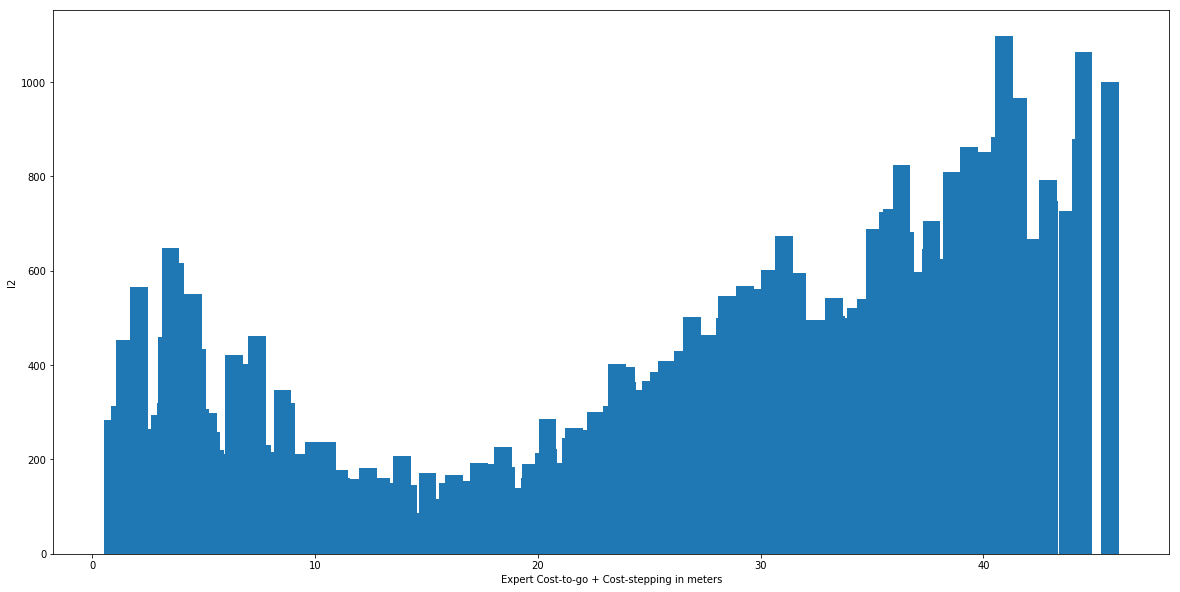

In [134]:
plot_loss_grouped_by_q_target_size(val_unseen_l2_results, 'l2')

## Set 4: Plot loss by expert cost-to-go

In [127]:
def compute_loss_by_cost_togo_targets(results):

    tars = []
    preds = []

    for task in results:

        timesteps = len(task['agent_q_values'])

        for t in range(timesteps):
            tars += [val for val in task['teacher_cost_togo'][t] if val != 1e9]
            preds += [val for val in task['agent_q_values'][t] if val != 1e9]

    l1_losses = np.abs(np.array(tars) - np.array(preds))
    l2_losses = (np.array(tars) - np.array(preds))**2

    return np.array(tars), np.array(preds), l1_losses, l2_losses

In [88]:
val_seen_l1_tars, val_seen_l1_preds, val_seen_l1_losses, _ = compute_loss_by_cost_togo_targets(val_seen_l1_results)
val_seen_l2_tars, val_seen_l2_preds, _, val_seen_l2_losses = compute_loss_by_cost_togo_targets(val_seen_l2_results)

val_unseen_l1_tars, val_unseen_l1_preds, val_unseen_l1_losses, _ = compute_loss_by_cost_togo_targets(val_unseen_l1_results)
val_unseen_l2_tars, val_unseen_l2_preds, _, val_unseen_l2_losses = compute_loss_by_cost_togo_targets(val_unseen_l2_results)

In [135]:
def plot_loss_grouped_by_cost_togo_size(results, loss_str, sample_size=5000):
    tars, preds, l1_losses, l2_losses = compute_loss_by_cost_togo_targets(results)
    indices = np.random.choice(len(tars), size=sample_size)
  
    plt.figure(figsize=(20,10))
    if loss_str == 'l1':
        plt.bar(tars[indices], l1_losses[indices])
    else:
        plt.bar(tars[indices], l2_losses[indices])
    plt.xlabel('Expert cost-to-go in meters')
    plt.ylabel(loss_str)

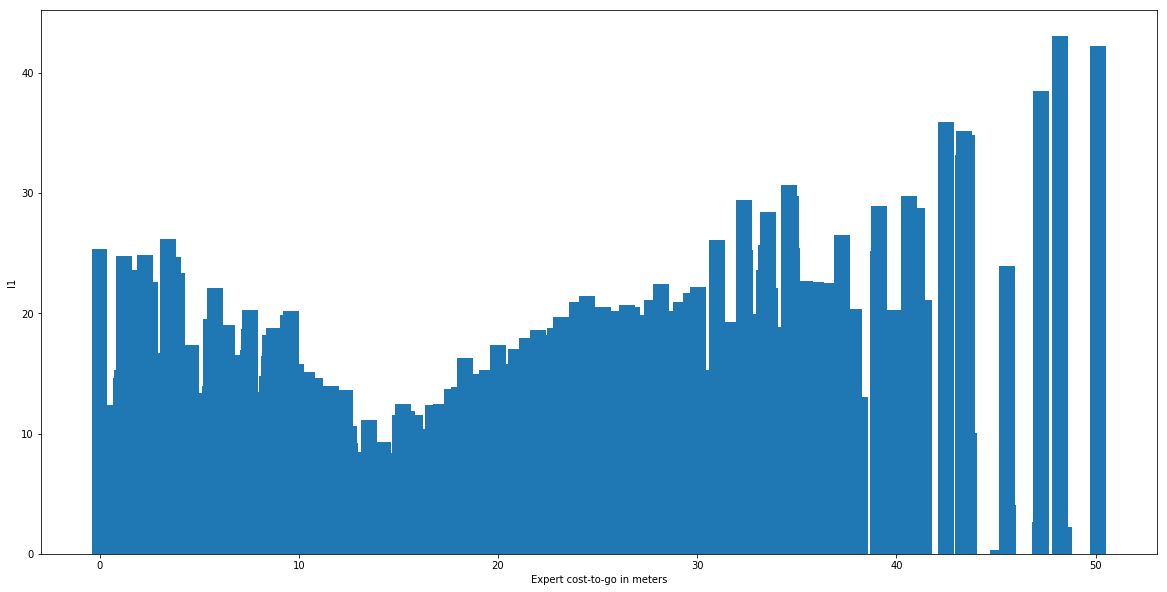

In [136]:
plot_loss_grouped_by_cost_togo_size(val_seen_l1_results, 'l1')

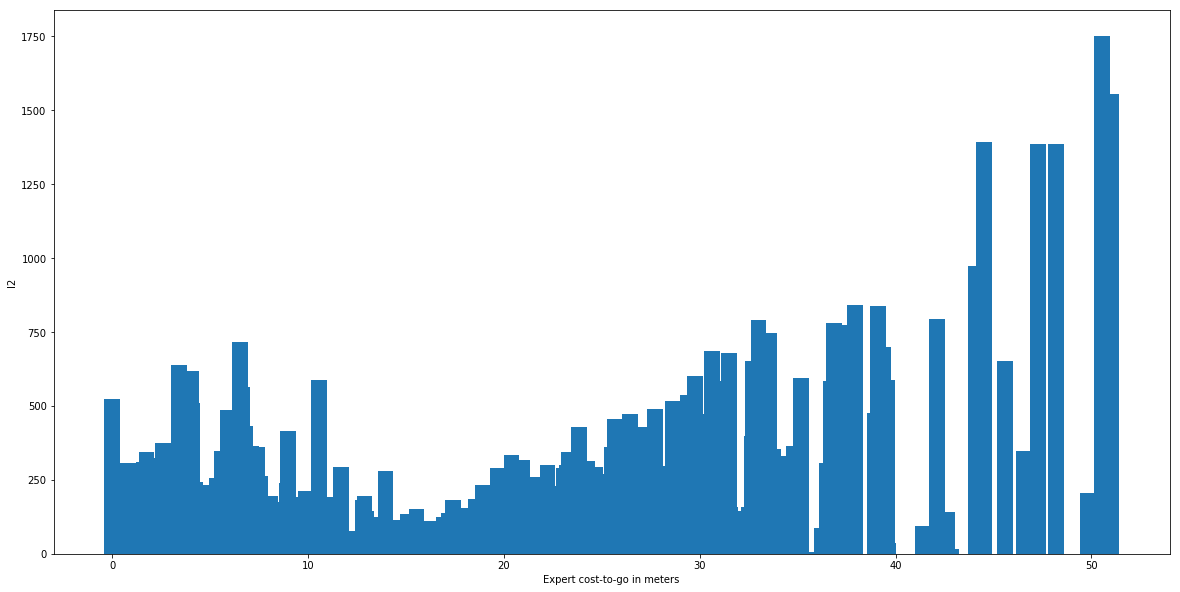

In [137]:
plot_loss_grouped_by_cost_togo_size(val_seen_l2_results, 'l2')

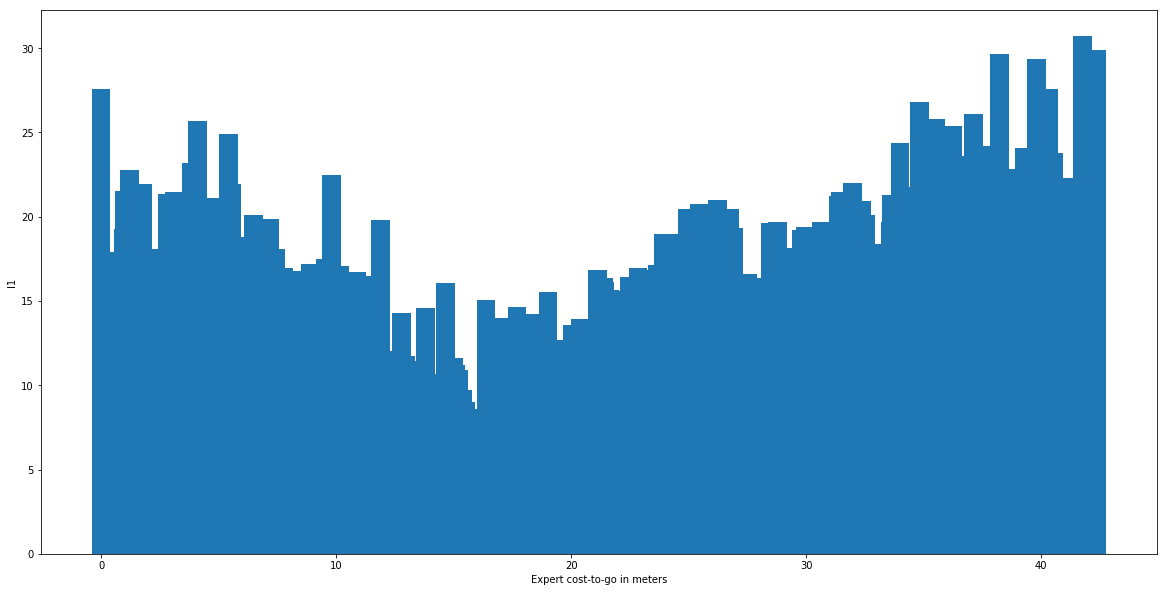

In [138]:
plot_loss_grouped_by_cost_togo_size(val_unseen_l1_results, 'l1')

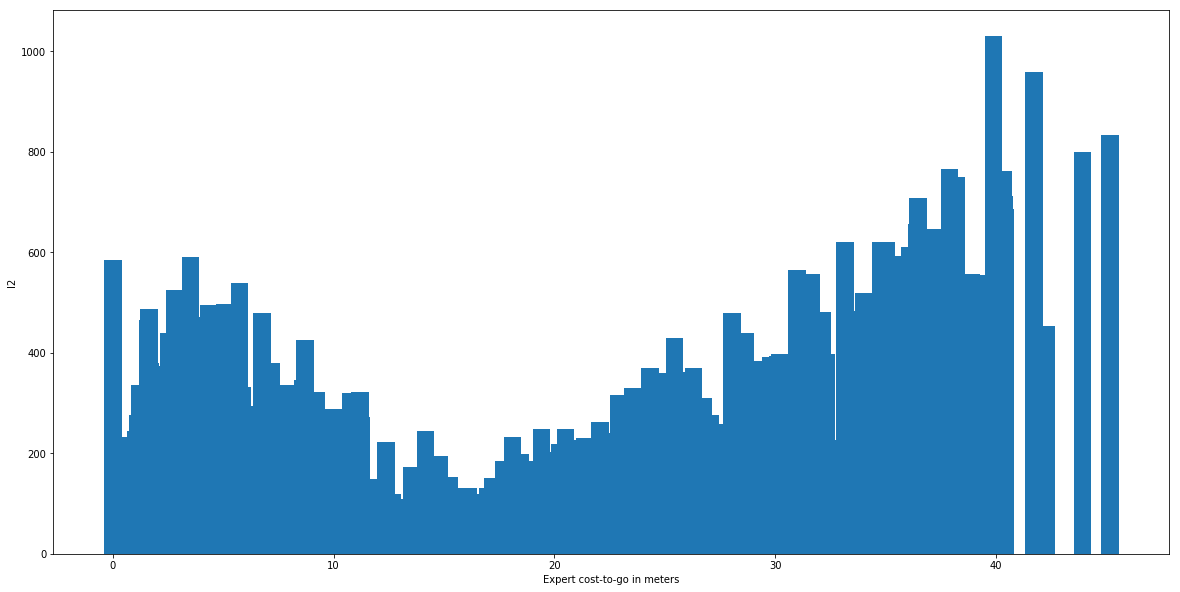

In [139]:
plot_loss_grouped_by_cost_togo_size(val_unseen_l2_results, 'l2')

## Set 5: Plot loss by expert cost-stepping

In [140]:
def compute_loss_by_cost_stepping_targets(results):

    tars = []
    preds = []

    for task in results:

        timesteps = len(task['agent_q_values'])

        for t in range(timesteps):
            tars += [val for val in task['teacher_cost_stepping'][t] if val != 1e9]
            preds += [val for val in task['agent_q_values'][t] if val != 1e9]

    l1_losses = np.abs(np.array(tars) - np.array(preds))
    l2_losses = (np.array(tars) - np.array(preds))**2

    return np.array(tars), np.array(preds), l1_losses, l2_losses

In [141]:
val_seen_l1_tars, val_seen_l1_preds, val_seen_l1_losses, _ = compute_loss_by_cost_stepping_targets(val_seen_l1_results)
val_seen_l2_tars, val_seen_l2_preds, _, val_seen_l2_losses = compute_loss_by_cost_stepping_targets(val_seen_l2_results)

val_unseen_l1_tars, val_unseen_l1_preds, val_unseen_l1_losses, _ = compute_loss_by_cost_stepping_targets(val_unseen_l1_results)
val_unseen_l2_tars, val_unseen_l2_preds, _, val_unseen_l2_losses = compute_loss_by_cost_stepping_targets(val_unseen_l2_results)

In [142]:
def plot_loss_grouped_by_cost_stepping_size(results, loss_str, sample_size=5000):
    tars, preds, l1_losses, l2_losses = compute_loss_by_cost_stepping_targets(results)
    indices = np.random.choice(len(tars), size=sample_size)
  
    plt.figure(figsize=(20,10))
    if loss_str == 'l1':
        plt.bar(tars[indices], l1_losses[indices])
    else:
        plt.bar(tars[indices], l2_losses[indices])
    plt.ylabel(loss_str)
    plt.xlabel('Expert cost-stepping')

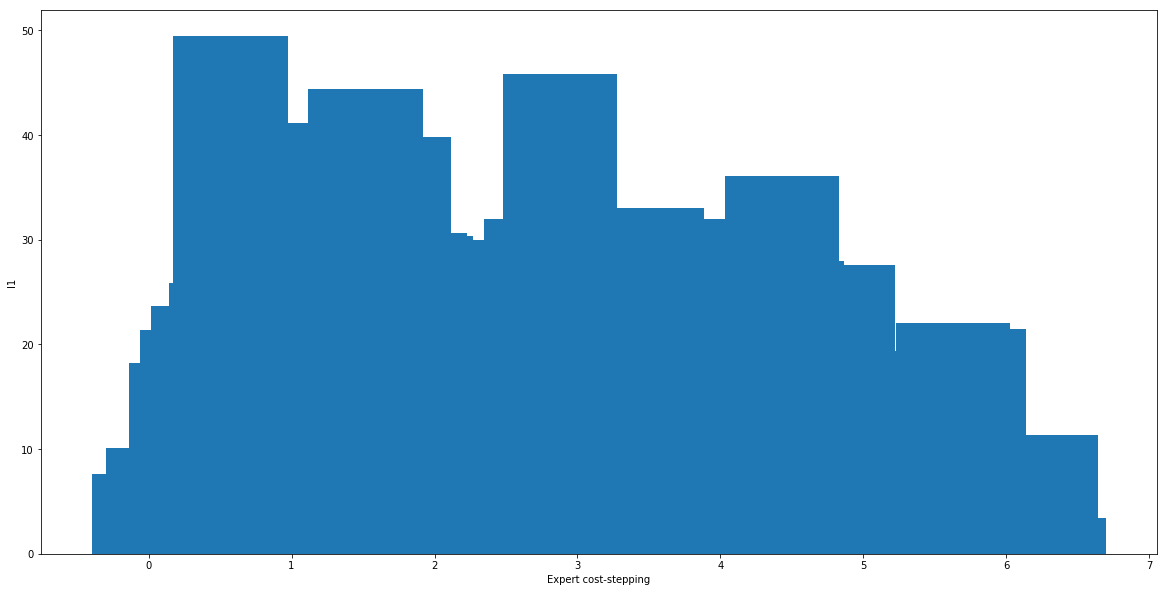

In [143]:
plot_loss_grouped_by_cost_stepping_size(val_seen_l1_results, 'l1')

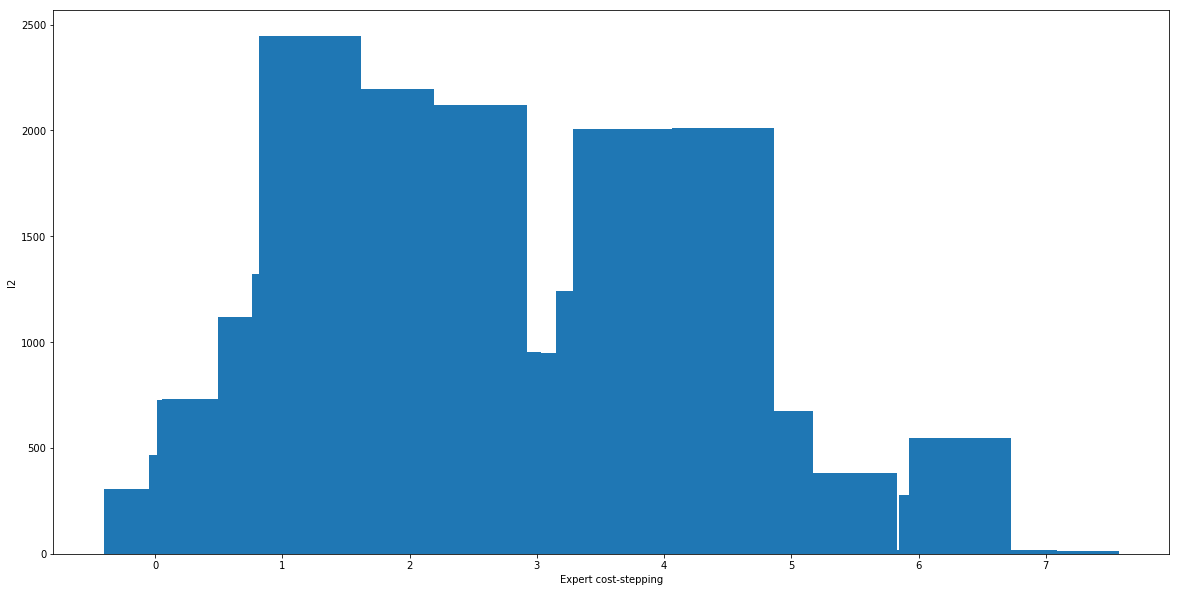

In [144]:
plot_loss_grouped_by_cost_stepping_size(val_seen_l2_results, 'l2')

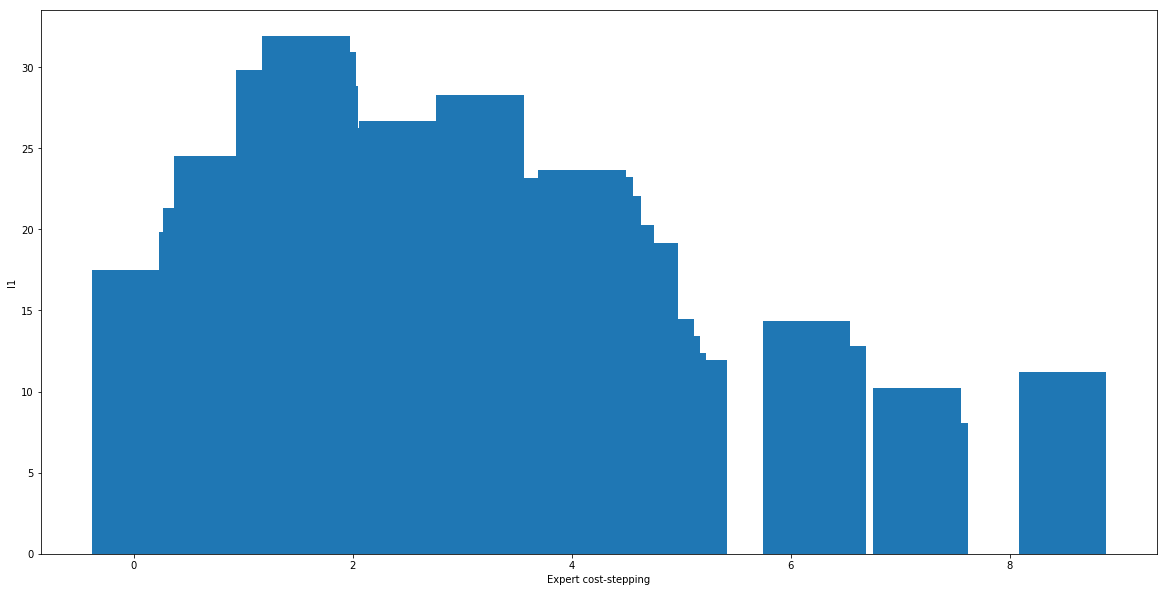

In [145]:
plot_loss_grouped_by_cost_stepping_size(val_unseen_l1_results, 'l1')

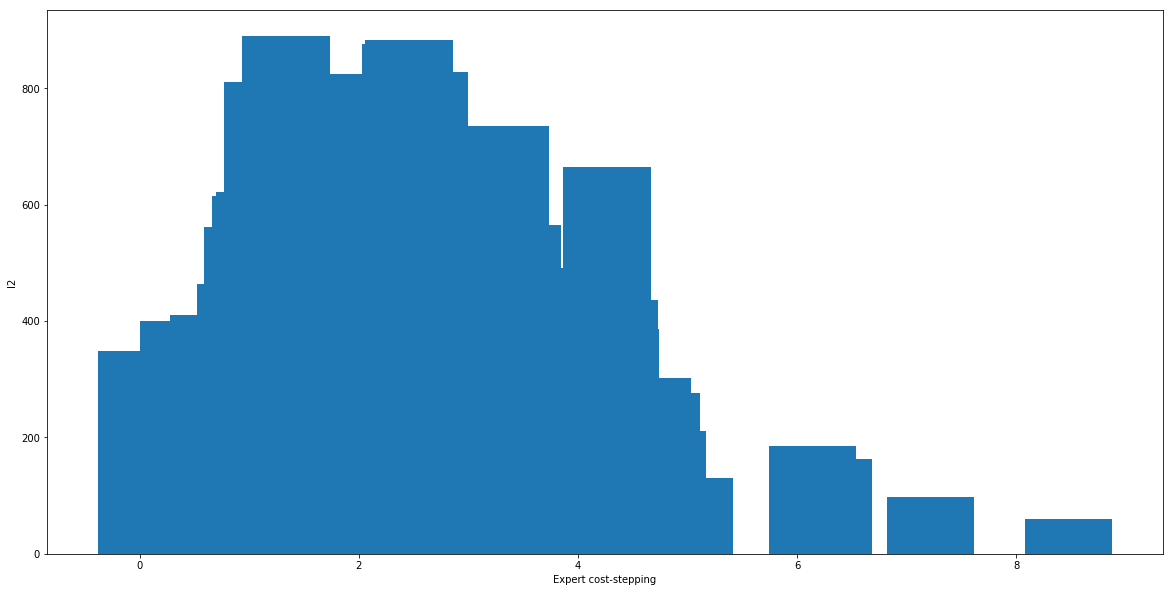

In [146]:
plot_loss_grouped_by_cost_stepping_size(val_unseen_l2_results, 'l2')

## Does the agent go back to its previous steps?

In [21]:
def compress_trajectory(traj_list):
    
    curr_v = traj_list[0][0]
    compressed_traj = [curr_v]
    for step in traj_list:
        if step[0] != curr_v:
            curr_v = step[0]
            compressed_traj.append(curr_v)
            
    return compressed_traj

In [22]:
def check_duplicates(traj_list):
    compressed_traj = compress_trajectory(traj_list)
    return Counter(compressed_traj).most_common()[0][1]

In [34]:
def count_duplicates_for_results(results):
    duplicates_count = []
    for res in results:
        duplicates_count.append(check_duplicates(res['trajectory']))

    return duplicates_count, len([ct for ct in duplicates_count if ct > 1]) * 1.0 / len(results)

In [83]:
def compute_graph_size_per_dup_count(results):
    duplicates_list, duplicates_frac = count_duplicates_for_results(results)
    
    dup_ct_scan_list = defaultdict(list)
    for i, dup_ct in enumerate(duplicates_list):
        dup_ct_scan_list[dup_ct].append(results[i]['scan'])
        
    dup_ct_graph_size = {}

    for dup_ct in dup_ct_scan_list:

        scan_list = dup_ct_scan_list[dup_ct]
        graph_sizes = []
        for scan in scan_list:
            G = utils.load_nav_graphs(scan)
            graph_sizes.append(len(G))

        dup_ct_graph_size[dup_ct] = np.mean(graph_sizes)
        
    return Counter(duplicates_list), dup_ct_graph_size

In [84]:
counter, avg_graph_size = compute_graph_size_per_dup_count(val_seen_l2_results)

In [85]:
counter

Counter({1: 2315,
         2: 1491,
         3: 576,
         4: 292,
         5: 171,
         6: 24,
         7: 2,
         8: 1,
         12: 1,
         13: 1})

In [86]:
avg_graph_size

{1: 134.37365010799135,
 2: 122.79946344735077,
 3: 129.34548611111111,
 4: 122.57191780821918,
 5: 140.859649122807,
 6: 107.0,
 7: 251.0,
 8: 345.0,
 12: 109.0,
 13: 345.0}

### Group by room types (ignore, DSVM dead)

In [149]:
all_panos_to_region = {}
val_seen_scans = [res['scan'] for res in val_seen_l1_results]
val_unseen_scans = [res['scan'] for res in val_unseen_l1_results]

for scan in val_seen_scans:
    if scan not in all_panos_to_region.keys():
        all_panos_to_region[scan] = utils.load_panos_to_region(scan, '')
        
for scan in val_unseen_scans:
    if scan not in all_panos_to_region.keys():
        all_panos_to_region[scan] = utils.load_panos_to_region(scan, '')

In [150]:
def compute_loss_by_room_types(results):

    tars = []
    preds = []
    rms_curr = []
    rms_next = []

    for task in results:

        timesteps = len(task['agent_q_values'])
        scan = task['scan']
        
        for t in range(timesteps):
            tars += [val for val in task['teacher_q_values'][t] if val != 1e9]
            preds += [val for val in task['agent_q_values'][t] if val != 1e9]
            vertex_curr = task['trajectory'][t][0]
            vertex_next = task['trajectory'][t+1][0]
#             import pdb; pdb.set_trace()
            rm_label_curr = all_panos_to_region[scan][vertex_curr]
            rm_label_next = all_panos_to_region[scan][vertex_next]
            
            rms_curr += [rm_label_curr for _ in range(len(tars))]
            rms_next += [rm_label_next for _ in range(len(tars))]

    l1_losses = np.abs(np.array(tars) - np.array(preds))
    l2_losses = (np.array(tars) - np.array(preds))**2

    return np.array(tars), np.array(preds), l1_losses, l2_losses, rms_curr, rms_next

In [151]:
val_unseen_l2_results[0].keys()

dict_keys(['agent_q_values', 'expert_rollin_bool', 'instr_id', 'teacher_q_values', 'trajectory', 'teacher_cost_stepping', 'teacher_cost_togo', 'agent_nav', 'beta', 'scan'])

In [152]:
tars, preds, l1_losses, l2_losses, rms_curr, rms_next = compute_loss_by_room_types(val_unseen_l2_results)

In [157]:
def plot_loss_grouped_by_rm_types(tars, preds, l1_losses, l2_losses, rms_curr, rms_next, sample_size=5000):

    indices = np.random.choice(len(tars), size=sample_size)
  
    plt.figure(figsize=(20,10))
    if loss_str == 'l1':
        if rm_str == 'curr':
            plt.bar(rms_curr[indices], l1_losses[indices])
        else:
            plt.bar(rms_next[indices], l1_losses[indices])
    else:
        if rm_str == 'curr':
            plt.bar(rms_curr[indices], l2_losses[indices])
        else:
            plt.bar(rms_next[indices], l1_losses[indices])
    plt.ylabel(loss_str)
    plt.xlable('Room Type')

Exception ignored in: 'zmq.backend.cython.message.Frame.__dealloc__'
Traceback (most recent call last):
  File "zmq/backend/cython/checkrc.pxd", line 12, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt


In [158]:
plot_loss_grouped_by_rm_types(val_seen_l1_results, 'l1')
plot_loss_grouped_by_rm_types(val_seen_l2_results, 'l2')
plot_loss_grouped_by_rm_types(val_unseen_l1_results, 'l1')
plot_loss_grouped_by_rm_types(val_unseen_l2_results, 'l2')

TypeError: plot_loss_grouped_by_rm_types() missing 4 required positional arguments: 'l1_losses', 'l2_losses', 'rms_curr', and 'rms_next'